In [1]:
import pandas as pd

# Cargar archivo

df = pd.read_pickle("WRF_DataT2RH2-allxy-allTime_dia1_2015.pkl")


# Mostrar información general
print("\n📌 Información del DataFrame:")
print(df.info())

# Primeras filas
print("\n📌 Primeras filas del archivo:")
print(df.head())

# Valores únicos de lat/lon
print("\n📌 Coordenadas únicas disponibles:")
print(df[['lat', 'lon']].drop_duplicates().head(10))  # mostrar solo 10 para no saturar

# Rango de fechas
print("\n📌 Rango de fechas:")
print(f"Desde: {df['fecha_modelo'].min()}  Hasta: {df['fecha_modelo'].max()}")

# Cantidad de puntos y registros
print("\n📌 Cantidad total de filas:", len(df))
print("📌 Número de puntos únicos:", len(df[['lat','lon']].drop_duplicates()))



📌 Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070107 entries, 0 to 5070106
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   fecha_modelo  object 
 1   hora          int64  
 2   lat           float32
 3   lon           float32
 4   HGT           float64
 5   T2            float64
 6   RH2           float64
dtypes: float32(2), float64(3), int64(1), object(1)
memory usage: 232.1+ MB
None

📌 Primeras filas del archivo:
  fecha_modelo  hora        lat        lon         HGT         T2        RH2
0   2015-01-02     0 -33.178204 -71.683090  189.884247  15.791901  70.491035
1   2015-01-02     0 -33.178204 -71.672699  252.514252  15.819397  69.495125
2   2015-01-02     0 -33.178204 -71.662315  311.148193  15.847504  68.565086
3   2015-01-02     0 -33.178204 -71.651932  363.760681  15.876190  67.763191
4   2015-01-02     0 -33.178204 -71.641541  407.532715  15.905548  66.862099

📌 Coordenadas únicas disponibles:
      

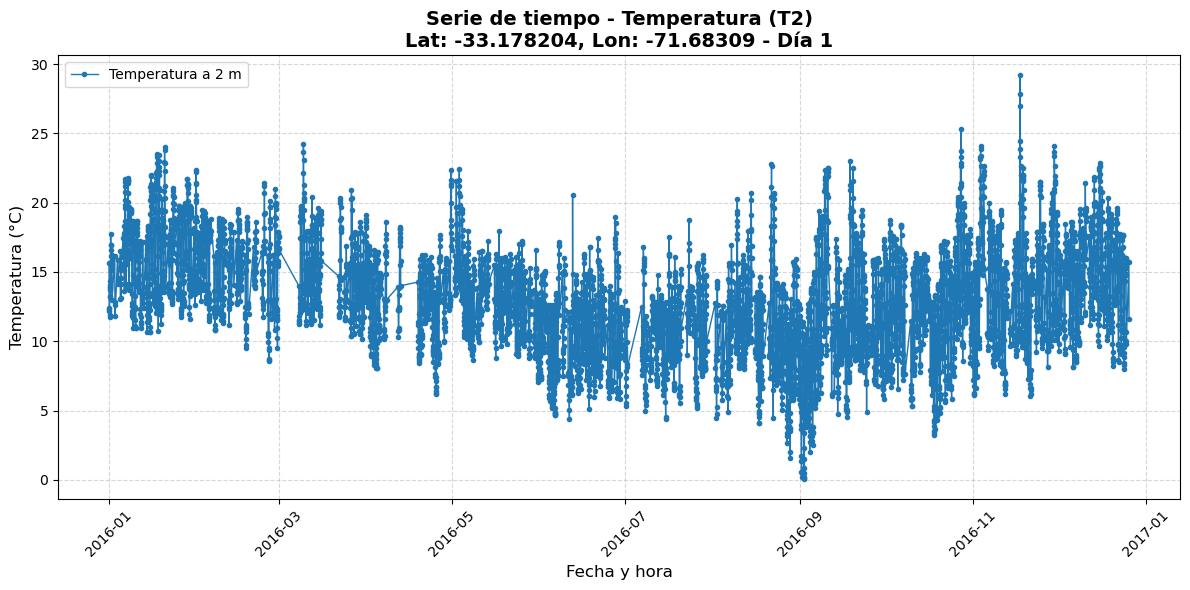

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar archivo ===
df = pd.read_pickle("WRF_DataT2RH2-SUPxy-allTime_dia1_2016.pkl")

# === 2. Elegir una coordenada específica (lat, lon) ===
lat_obj = -33.178204    # Coordenada de referencia
lon_obj = -71.683090

# Filtrar por coordenada
df_sel = df[(df['lat'] == lat_obj) & (df['lon'] == lon_obj)].copy()

# Crear columna datetime
df_sel['datetime'] = pd.to_datetime(df_sel['fecha_modelo'].astype(str)) + pd.to_timedelta(df_sel['hora'], unit='h')

# === 3. Gráfico mejorado ===
plt.figure(figsize=(12, 6))
plt.plot(
    df_sel['datetime'], 
    df_sel['T2'], 
    marker='o', 
    markersize=3, 
    linewidth=1,
    color='tab:blue',
    label="Temperatura a 2 m"
)

# Decoración
plt.title(f"Serie de tiempo - Temperatura (T2)\nLat: {lat_obj}, Lon: {lon_obj} - Día 1", fontsize=14, fontweight='bold')
plt.xlabel("Fecha y hora", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Mostrar
plt.show()


In [21]:
import pandas as pd
import numpy as np
import folium
from branca.colormap import LinearColormap

# === Parámetros ===
pkl_path = "WRF_DataT2RH2-SUPxy-allTime_dia1_2016.pkl"
date_str = "2016-01-25"
hour_sel = 16


# === Cargar datos ===
df = pd.read_pickle(pkl_path)
df["fecha_modelo"] = pd.to_datetime(df["fecha_modelo"], errors="coerce")

mask = (df["fecha_modelo"].dt.date == pd.to_datetime(date_str).date()) & (df["hora"] == hour_sel)
df_day = df.loc[mask, ["lat", "lon", "T2", "HGT"]].copy()
if df_day.empty:
    raise ValueError(f"Sin datos para {date_str} a las {hour_sel}:00.")

# === Rango y colormap (simple) ===
vmin = float(np.nanmin(df_day["T2"]))
vmax = float(np.nanmax(df_day["T2"]))
if vmin == vmax:
    vmax = vmin + 1e-6  # evita división por cero

# Paleta corta (viridis-like)
palette = ["#440154", "#31688e", "#35b779", "#fde725"]
cmap = LinearColormap(palette, vmin=vmin, vmax=vmax, caption=f"T2 (°C) — {date_str} {hour_sel:02d}:00").to_step(10)

# === Mapa ===
m = folium.Map(
    location=[float(df_day["lat"].mean()), float(df_day["lon"].mean())],
    zoom_start=8,
    tiles="CartoDB positron"
)

for _, r in df_day.iterrows():
    val = float(r["T2"])
    folium.CircleMarker(
        location=[float(r["lat"]), float(r["lon"])],
        radius=4,
        weight=0.6,
        fill=True,
        fill_opacity=0.9,
        color=cmap(val),
        tooltip=(f"<b>T2:</b> {val:.2f} °C<br>"
                 f"<b>Lat:</b> {r['lat']:.6f}<br>"
                 f"<b>Lon:</b> {r['lon']:.6f}<br>"
                 f"<b>HGT:</b> {r['HGT']:.1f} m")
    ).add_to(m)

cmap.add_to(m)

out_html = f"mapa_T2_{date_str}_{hour_sel:02d}.html"
m.save(out_html)
print(f"Mapa guardado en: {out_html}")


Mapa guardado en: mapa_T2_2016-01-25_16.html


In [22]:
m

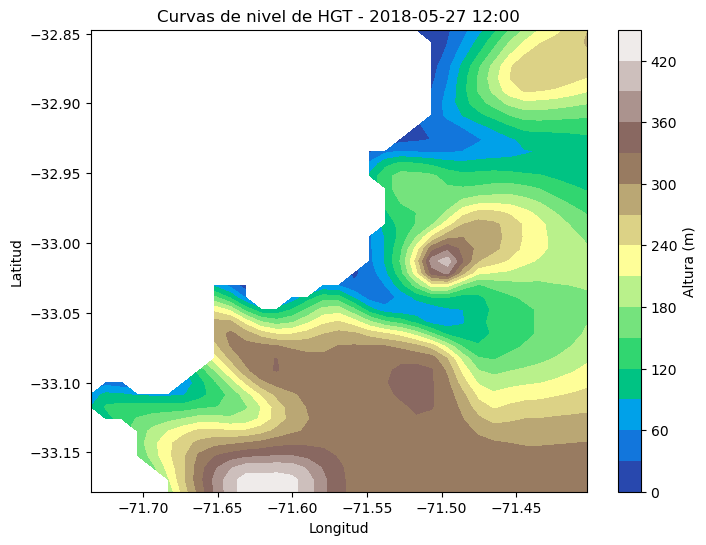

In [20]:

import matplotlib.pyplot as plt
import numpy as np

# Pivotar datos para grilla
pivot = df_sel.pivot_table(index='lat', columns='lon', values='HGT')

# Ordenar latitud y longitud
lats = np.array(sorted(df_sel['lat'].unique()))
lons = np.array(sorted(df_sel['lon'].unique()))

HGT_grid = pivot.values

plt.figure(figsize=(8,6))
cs = plt.contourf(lons, lats, HGT_grid, cmap='terrain', levels=15)
plt.colorbar(cs, label='Altura (m)')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Curvas de nivel de HGT - 2018-05-27 12:00")
plt.show()
